# Import Library and Framework

In [1]:
%load_ext tensorboard

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import os

# Variables Declaration

In [5]:
name_ = 'Base'
model_name = 'ResNet50_'+name_ #Ganti nama dengan file jupy

epochs = 40 #Jumlah epoch pelatihan
batch_size = 32 #Batch Size
tensor_size = (224,224) #Ukuran size citra input model
color_mode = 'rgb' #Mode rgb untuk convert

folder_path = 'C:\\MyFile\\CAPSTONE\\DATASET\\Fold\\Fold_2' #Folder dari dataset, di dalam Folder itu harus terdapat...
train_path = os.path.join(folder_path,'Train') #...Folder Train dan ...
val_path = os.path.join(folder_path,'Validation') #...Folder Validation

featurewise_center = True #Centering/Whitening featurewise menggunakan mean per channel
featurewise_std_normalization = True #Normalisasi featurewise menggunakan std per channel

mean_per_channel = np.load('mean_per_channel_train_fold_2.npy') #Mengambil file numpy mean dari folder sekarang
std_per_channel = np.load('std_per_channel_train_fold_2.npy') #Mengambil file numpy std dari folder sekarang

x_ax = np.arange(1,epochs+1) #Numpy Array untuk keperluan menyimpan loss



# Model 

In [3]:
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, BatchNormalization, Activation, add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [4]:
def blok_A(input_, filters1, filters2):
    #blok tanpa conv shortcut
    x = input_
    
    x = Conv2D(filters1, (1,1), kernel_initializer='he_normal')(x) #initializer sesuai dengan paper asli ResNet
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters1, (3,3), kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters2, (1,1), kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    
    x = add([x, input_])
    x = Activation('relu')(x)
    
    return x

In [5]:
def blok_B(input_, filters1, filters2, stride_=(2,2)):
    #blok dengan conv shortcut dan stride 2
    x = input_
    
    x = Conv2D(filters1, (1,1), strides=stride_, kernel_initializer='he_normal',padding='valid')(x) #initializer sesuai dengan paper asli ResNet
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters1, (3,3), kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters2, (1,1), kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    
    #Shorcut connection
    short_ = Conv2D(filters2, (1,1), strides=stride_, kernel_initializer='he_normal')(input_) #initializer sesuai dengan paper asli ResNet
    short_ = BatchNormalization(axis=3)(short_)
    
    #Add
    x = add([x, short_])
    x = Activation('relu')(x)
    
    return x

In [6]:
#ResNet50

input_ = Input(shape=(224,224,3))

x = ZeroPadding2D((3,3))(input_)
x = Conv2D(64, (7,7), strides=(2,2), kernel_initializer='he_normal')(x)
x = BatchNormalization(axis=3)(x)
x = Activation('relu')(x)
x = ZeroPadding2D((1,1))(x)
x = MaxPooling2D((3,3),strides=(2,2))(x)


x = blok_B(x, 64, 256, (1,1))
x = blok_A(x, 64, 256)
x = blok_A(x, 64, 256)

x = blok_B(x, 128, 512)
x = blok_A(x, 128, 512)
x = blok_A(x, 128, 512)
x = blok_A(x, 128, 512)

x = blok_B(x, 256, 1024)
x = blok_A(x, 256, 1024)
x = blok_A(x, 256, 1024)
x = blok_A(x, 256, 1024)
x = blok_A(x, 256, 1024)
x = blok_A(x, 256, 1024)

x = blok_B(x, 512, 2048)
x = blok_A(x, 512, 2048)
x = blok_A(x, 512, 2048)

x = GlobalAveragePooling2D()(x)
x = Dense(2, 'softmax')(x)

Model_ResNet50 = Model(input_,x, name=name_)

In [7]:
Model_ResNet50.summary()

Model: "ReFold_2_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
________________________________________________________________________________________

In [8]:
Model_ResNet50.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

## Data Generator

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
datagen = ImageDataGenerator(featurewise_center=featurewise_center, 
                             featurewise_std_normalization=featurewise_std_normalization)

In [12]:
mean_per_channel

array([116.66758984, 116.66639649, 116.66500506])

In [13]:
std_per_channel

array([77.59071582, 77.59128068, 77.58857241])

In [14]:
datagen.mean = mean_per_channel
datagen.std = std_per_channel

In [15]:
training_gen = datagen.flow_from_directory(directory=train_path,
                                           target_size=tensor_size,
                                           color_mode=color_mode,
                                           batch_size=batch_size)

Found 22001 images belonging to 2 classes.


In [16]:
validation_gen = datagen.flow_from_directory(directory=val_path,
                                           target_size=tensor_size,
                                           color_mode=color_mode,
                                           batch_size=batch_size)

Found 5501 images belonging to 2 classes.


In [17]:
training_gen.class_indices

{'Negatif': 0, 'Positif': 1}

In [18]:
validation_gen.class_indices

{'Negatif': 0, 'Positif': 1}

## TensorBoard

In [19]:
from tensorflow.keras.callbacks import TensorBoard

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## Training

In [22]:
Model_ResNet50.fit(x=training_gen,
                   epochs=epochs,
                   validation_data=validation_gen,
                   callbacks=[tensorboard_callback])

Epoch 1/40
688/688 [==============================] - 224s 313ms/step - loss: 0.4384 - accuracy: 0.8163 - val_loss: 0.4081 - val_accuracy: 0.8682
Epoch 2/40
688/688 [==============================] - 212s 307ms/step - loss: 0.1802 - accuracy: 0.9251 - val_loss: 0.2226 - val_accuracy: 0.9169
Epoch 3/40
688/688 [==============================] - 212s 308ms/step - loss: 0.1306 - accuracy: 0.9474 - val_loss: 0.4769 - val_accuracy: 0.8175
Epoch 4/40
688/688 [==============================] - 213s 309ms/step - loss: 0.0975 - accuracy: 0.9618 - val_loss: 0.0751 - val_accuracy: 0.9740
Epoch 5/40
688/688 [==============================] - 213s 309ms/step - loss: 0.0793 - accuracy: 0.9707 - val_loss: 0.0732 - val_accuracy: 0.9729
Epoch 6/40
688/688 [==============================] - 213s 310ms/step - loss: 0.0726 - accuracy: 0.9729 - val_loss: 0.2145 - val_accuracy: 0.9333
Epoch 7/40
688/688 [==============================] - 213s 309ms/step - loss: 0.0688 - accuracy: 0.9734 - val_loss: 0.0969 -

In [24]:
loss = Model_ResNet50.history.history
loss_df = pd.DataFrame(loss,index=x_ax)
loss_df.to_excel('loss_'+name_+'.xlsx')
loss_df.to_csv('loss_'+name_+'.csv')

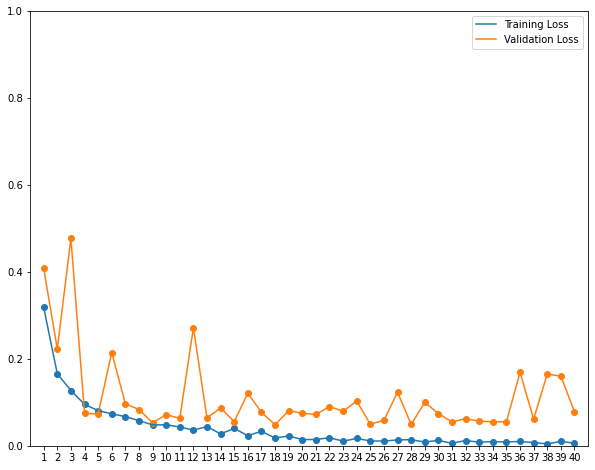

In [25]:
plt.figure(figsize=(10,8))
plt.plot(x_ax, loss_df['loss'],label='Training Loss')
plt.scatter(x_ax, loss_df['loss'])
plt.plot(x_ax, loss_df['val_loss'],label='Validation Loss')
plt.scatter(x_ax, loss_df['val_loss'])
plt.xlim(0,epochs+1)
plt.ylim(0,1)
plt.xticks(x_ax)
plt.legend(loc='upper right')

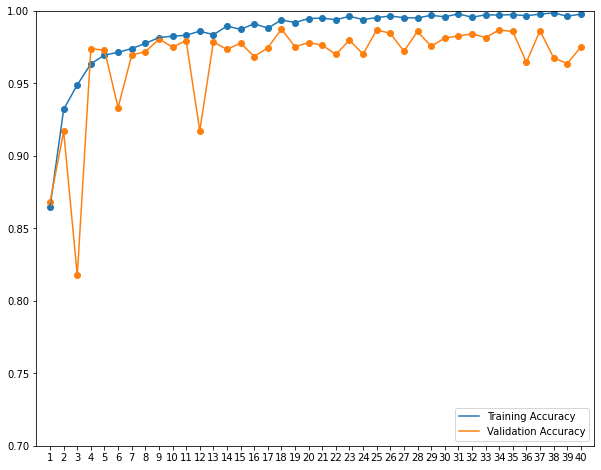

In [26]:
plt.figure(figsize=(10,8))
plt.plot(x_ax, loss_df['accuracy'],label='Training Accuracy')
plt.scatter(x_ax, loss_df['accuracy'])
plt.plot(x_ax, loss_df['val_accuracy'],label='Validation Accuracy')
plt.scatter(x_ax, loss_df['val_accuracy'])
plt.xlim(0,epochs+1)
plt.ylim(0.7,1)
plt.xticks(x_ax)
plt.legend(loc='lower right')

## Validation

In [27]:
validtest_gen = datagen.flow_from_directory(directory=val_path,
                                            target_size=tensor_size,
                                            color_mode='rgb',
                                            batch_size=1,
                                            shuffle=False)

validtest_gen.reset()

Found 5501 images belonging to 2 classes.


In [28]:
predict_proba = Model_ResNet50.predict(validtest_gen)

In [29]:
predict_proba.shape

(5501, 2)

In [30]:
predict = np.argmax(predict_proba, axis=1)

In [31]:
predict

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [32]:
y_true = np.array(validtest_gen.classes)

In [33]:
predict.shape

(5501,)

In [34]:
y_true.shape

(5501,)

## Confusion Matrix and Classification Report

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [36]:
cm = confusion_matrix(y_true, predict)

In [37]:
print(classification_report(y_true, predict))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3917
           1       0.94      0.97      0.96      1584

    accuracy                           0.98      5501
   macro avg       0.97      0.97      0.97      5501
weighted avg       0.98      0.98      0.98      5501



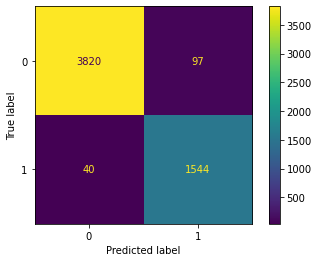

In [38]:
cm_display = ConfusionMatrixDisplay(cm).plot()

## ROC Curve

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

In [40]:
fpr, tpr, _ = roc_curve(y_true[:,np.newaxis], predict_proba[:,1])

Text(0, 0.5, 'True Positive Rate')

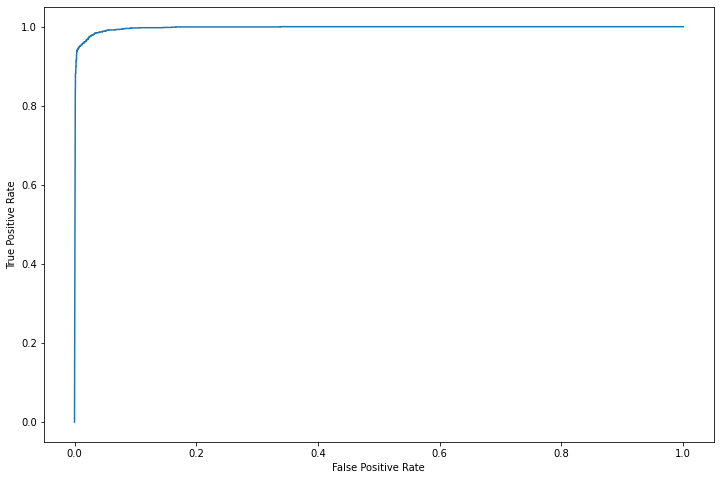

In [41]:
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
np.save(model_name+'fpr.npy', fpr)
np.save(model_name+'tpr.npy', tpr)

## AUC of ROC Curve

In [42]:
from sklearn.metrics import roc_auc_score

In [43]:
roc_auc_score(y_true[:,np.newaxis], predict_proba[:,1])

0.9971237941064978

## Save Model

In [44]:
Model_ResNet50.save(model_name)

INFO:tensorflow:Assets written to: ResNet50_ReFold_2_40\assets


In [45]:
Model_ResNet50.save(model_name+'.h5')